In [2]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [3]:
class Lipschitz_Layer (nn.Module):
    def __init__(self, in_dim , out_dim, B):
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.fc = nn.Linear(in_dim, out_dim)
        self.B_1 = torch.rand(1) * self.B
        self.register_parameter(name='fc1_max_layer_norm', param=torch.nn.Parameter(self.B_1))
        self.activation = nn.ReLU()
    
    def forward(self, x):
        return self.activation(self.fc(x))
    
    def grad(self):
        


        

SyntaxError: incomplete input (348181365.py, line 18)

In [14]:
class UniNN(nn.Module):
    def __init__(self, hidden,B = 2):
        super(UniNN, self).__init__()
        self.depth = 1
        self.device = "cpu"
        self.order = float('inf')
        self.B = B
        #if hidden > 500:
        #    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden = hidden       
        self.fc1 = nn.Linear(1, self.hidden)
        self.B_1 = torch.rand(1) * self.B
        self.register_parameter(name='fc1_max_layer_norm', param=torch.nn.Parameter(self.B_1))
        #self.dropout = nn.Dropout(p=0.1)
        #self.batch_norm = nn.BatchNorm1d(self.hidden)
        #self.activation = nn.ReLU()
        self.activation = nn.Tanh()

        self.fc2 = nn.Linear(self.hidden, 1)
        self.B_2 = torch.rand(1) * self.B
        self.register_parameter(name='fc2_max_layer_norm', param=torch.nn.Parameter(self.B_2))

        self.test_loss_reached = False
        self.end_test_loss = 0
        self.reg_lr = 1e-5         

    def forward(self, x):
        out_1 = self.fc1(x.to(self.device))
        out_act = self.activation(out_1)
        return self.fc2(out_act)

    def get_dataloader(self,f,num_samples=5000, batch_size = 32):
        X = torch.vstack((torch.rand(num_samples, 1), torch.zeros(num_samples //20 ,1)))
        train_dataset = torch.utils.data.TensorDataset(X, f(X))
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_dataloader

    def fit(self, dataloader, dataloader_test, epochs=100, lr=0.001, decay = 1e-3, B = 10):
        self.to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.RAdam([
            {'params': self.fc1.weight},
            {'params': self.fc1.bias},
            {'params': self.fc2.weight},
            {'params': self.fc2.bias}, 
        ], lr=lr)
        #optimizer_b = optim.RAdam([
        #], lr=1e-5)
        train_losses = []
        test_losses = []
        iters = 0
        epoch = 0
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=333, gamma=0.1)
        while True:
            epoch += 1
            self.train()
            running_train_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                overall_loss = loss #+ (self.fc1_max_layer_norm**2 + self.fc1_max_layer_norm**2) * self.reg_lr
                optimizer.zero_grad()
                running_train_loss += loss.item()
                self.compute_lipschitz_constant()
                overall_loss.backward()
                #print(self.fc3.weight.grad)
                self.compute_grad_B()
                self.update_B()
                optimizer.step()
                self.project_B()
                self.project_W()
                    
            avg_train_loss = running_train_loss / len(dataloader)
            train_losses.append(avg_train_loss)
            self.eval() 
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_test:
                    outputs = self(inputs.to(self.device))
                    loss = criterion(outputs, labels.to(self.device))
                    running_test_loss += loss.item()
                    
            avg_test_loss = running_test_loss / len(dataloader_test)
            test_losses.append(avg_test_loss)
            if avg_test_loss < 5e-3:
                iters += 1
            else:
                iters = 0
            if iters == 10:
                self.test_loss_reached = True
            scheduler.step()
            if epoch > 500:
                break
        self.end_test_loss = sum(test_losses[-5:]) / 5
        self.end_train_loss = sum(train_losses[-5:]) / 5  
        self.model_err_sup_norm()
        print(self.hidden, self.fc1_max_layer_norm.data, self.fc2_max_layer_norm.data, self.L, self.test_loss_reached, test_losses[-5:], self.reg_lr)
        
        return test_losses
    
    def update_B(self):
        #print(self.L)
        #print("fc1:", self.fc1_max_layer_norm.data, self.fc2_max_layer_norm.data, "before")
        self.fc1_max_layer_norm.data = self.fc1_max_layer_norm.data - 0.01 * self.grad_B_1
        self.fc2_max_layer_norm.data = self.fc2_max_layer_norm.data - 0.01 * self.grad_B_2
        #print("fc1:",self.fc1_max_layer_norm.data, self.fc2_max_layer_norm.data, "after")
        self.grad_B_1 = 0
        self.grad_B_2 = 0

    def compute_grad_B(self):
        self.grad_B_1 = torch.sum(self.fc1.weight.grad * (self.fc1.weight.data / torch.linalg.matrix_norm(self.fc1.weight.data, ord = self.order))) + 0.0005 * self.fc2_max_layer_norm * torch.exp(7 * ((self.fc1_max_layer_norm * self.fc2_max_layer_norm) - self.B))
        self.grad_B_2 = torch.sum(self.fc2.weight.grad * (self.fc2.weight.data / torch.linalg.matrix_norm(self.fc2.weight.data, ord = self.order))) + 0.0005 * self.fc1_max_layer_norm * torch.exp(7 * ((self.fc1_max_layer_norm * self.fc2_max_layer_norm) - self.B))

    def project_W(self):
        self.fc1.weight.data *= self.fc1_max_layer_norm / torch.linalg.matrix_norm(self.fc1.weight.data, ord = self.order)
        self.fc2.weight.data *= self.fc2_max_layer_norm / torch.linalg.matrix_norm(self.fc2.weight.data, ord = self.order)

    def project_B(self):
        return
        B1 = torch.clamp(self.fc1_max_layer_norm.data, min=1e-6, max=self.B)
        B2 = torch.clamp(self.fc2_max_layer_norm.data, min=1e-6, max=self.B)
        if B1 * B2 < self.B:
            return    
        
        #gamma = torch.sqrt(self.B / (B1 * B2))
        #B1 *= gamma
        #B2 *= gamma
        #if B1 < B2:
        #B1 = torch.clamp(B1, min=1e-6, max=self.B)
        #B2 = torch.clamp(B2, min=1e-6, max=self.B)
        self.fc1_max_layer_norm.data = B1
        self.fc2_max_layer_norm.data = B2
        #print(self.fc1_max_layer_norm.data, self.fc2_max_layer_norm.data)

    def plot_model(self, f, title):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1))
        print("estimated_sup_norm_error", torch.max(torch.abs(y_pred.view(-1) - f(x_train))))
        plt.plot(x_train.numpy(), y_pred.numpy(), label="Model")
        plt.plot(x_train.numpy(), f(x_train).numpy(), label="Objective")
        plt.title("Model Predictions vs Data" + ' decay:' + title)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def reg(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss += torch.linalg.matrix_norm(param, ord = 1)
        return reg_loss

    def model_err_sup_norm(self):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1)).to("cpu")
        self.sup_err = torch.max(torch.abs(y_pred.view(-1) - f(x_train)))

    def compute_lipschitz_constant(self):
        self.L = 1
        for name, param in self.named_parameters():
            if 'weight' in name:
                self.L *= torch.linalg.matrix_norm(param, ord = self.order)
                #self.L *= spectral_norm(param)
 


In [15]:
def f(X):
    return X**0.23

In [17]:
model = UniNN(16)
dataloader_train = model.get_dataloader(f)
dataloader_test = model.get_dataloader(f, num_samples=1000)
models = {}
Bs = [2] 
#Bs = [2]
#decays = [1e-2]
for i in range(9):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i, B = B)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=0, B = B)
        diction[2**i].append(model)
    models.update(diction)

1 tensor([2.3711]) tensor([0.9079]) tensor(2.1540, grad_fn=<MulBackward0>) False [0.006289923115576984, 0.006260373731933985, 0.006288399313096747, 0.0062789479623351135, 0.006332978966053237] 1e-05
2 tensor([2.5939]) tensor([0.8289]) tensor(2.1506, grad_fn=<MulBackward0>) False [0.0062343424440107565, 0.006275144349219221, 0.006263161296815131, 0.0062294548631391744, 0.006284774725579403] 1e-05
4 tensor([1.8578]) tensor([1.1773]) tensor(2.1867, grad_fn=<MulBackward0>) False [0.007049090183114238, 0.00706816396930001, 0.007096455965162904, 0.007045182554672162, 0.007066551557121177] 1e-05
8 tensor([1.7578]) tensor([1.2597]) tensor(2.2132, grad_fn=<MulBackward0>) False [0.008177649360291209, 0.008180090748338085, 0.008238068700655165, 0.008233418218989038, 0.008168003419555273] 1e-05
16 tensor([1.5378]) tensor([1.3899]) tensor(2.1368, grad_fn=<MulBackward0>) False [0.008532385207769094, 0.00853906602556394, 0.008519331381345788, 0.00846196866283814, 0.008481899410429778] 1e-05
32 tensor

In [123]:
for i in range(6,8):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=0, B = B)
        diction[2**i].append(model)
    models.update(diction)

64 tensor([3.1816]) tensor([0.7681]) tensor(2.4420, grad_fn=<MulBackward0>) False [0.008302290197179624, 0.008273573112532948, 0.008295258951627395, 0.008274776931626327, 0.008305565792728554] 1e-05
128 tensor([2.4688]) tensor([0.9432]) tensor(2.3282, grad_fn=<MulBackward0>) False [0.009182009849499798, 0.009233484884272471, 0.009249789696751219, 0.009250690553788885, 0.009229372424835508] 1e-05
256 tensor([1.9999]) tensor([1.0398]) tensor(2.0802, grad_fn=<MulBackward0>) False [0.009274871145008188, 0.009369844366147212, 0.009341000113636255, 0.009430812163786455, 0.009319415323041154] 1e-05


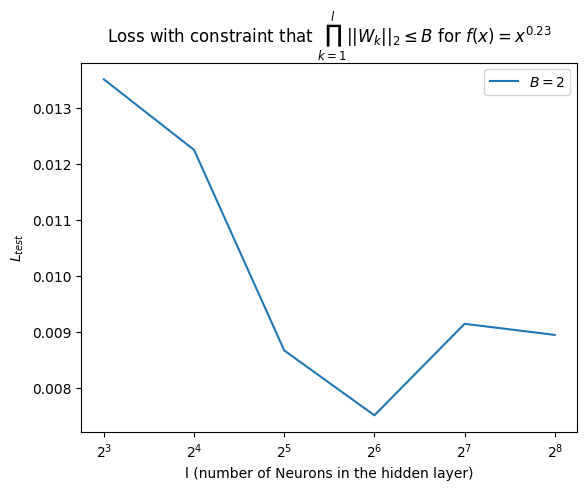

In [125]:
import matplotlib.pyplot as plt
for j,B in enumerate(Bs):
    #if j == 2:
    #    continue
    Err = []
    Neurons = []
    for i in range(3,9):
        Err.append(models[2**i][j].end_train_loss)
        #Err.append(models[2**i][j].end_test_loss)
        Neurons.append(2**i)
    if B > 100:
        plt.plot(Neurons,Err, label = r"$B = $" + r"$\infty$")
    else:
        plt.plot(Neurons,Err, label = r"$B = $" + f"{B}")
plt.xscale('log', base=2)
#plt.yscale('log')
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{test}$")
plt.title(r"Loss with constraint that $\prod^{l}_{k = 1}||W_k||_{2} \leq B$ for $f(x) = x^{0.23}$")
plt.legend()
plt.show()